<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Classification with K-Nearest Neighbors

_Authors: Kiefer Katovich (SF), Alexander Barriga (SF), Joseph Nelson (DC)_

---

### Learning Objectives
- Understand the difference between classification and regression models
- Understand the K-Nearest Neighbors algorithm visually and in pseudocode
- Explain the differences between distance metrics and explore the two most common
- Apply KNN classification to the Wisconsin breast cancer dataset
- Practice manually performing stratified cross-validation
- Visually examine the effect of K neighbors on the decision boundary
- Explain the effect of choosing K on the bias-variance tradeoff

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='intro'></a>

## Introduction: regression vs. classification

We've discussed the difference between continuous and discrete numbers. That difference is what distinguishes classification from regression prediction tasks. Today we are going to focus on predicting non-quantitative, discrete categories, which is known as classification.

Take wine for example. You could predict a quality rating using regression, but what if we just wanted to predict whether wine was good or bad? Red or white? 

Classification algorithms do just that; they predict categories, or classes. Split the data into groups and place new data into those groups. 

![](http://ipython-books.github.io/images/ml.png "Best Split vs Best Fit")

<a id='knn-visual-intro'></a>

---

### K-Nearest Neighbors (KNN) visually

**KNN works similarly to how we humans might choose to classify things. Below we have some red and blue dots:**
![Alt text](http://blog.yhat.com/static/img/knn_reds_and_blues.png "Some Dots")

**A new dot appears without a color and we need to decide which color it is most likely going to be.**
![Alt text](http://blog.yhat.com/static/img/knn_new_point.png "A New Dot Appears")

**We compare it to its three nearest neighbors – its neighbors are more often red, so we label it red.**
![Alt text](http://blog.yhat.com/static/img/knn_new_point_pred.png "3 Nearest Neighbors")

**What if we increase the number of neighbors to consider to 5?**
![Alt text](http://blog.yhat.com/static/img/knn_new_point_pred_blue.png "5 Nearest Neighbors")

**This is in essence the K-Nearest Neighbors (KNN) algorithm. The K represents the number of "neighbors" you use.**

> ***Images above credited to the yhat blog.***

<a id='knn'></a>

## The KNN algorithm

---

K-Nearest Neighbors takes a unique approach to finding patterns in the data. In order to estimate a value (regression) or class membership (classification), the algorithm finds the observations in its training data that are "nearest" to the observation to predict. It then takes a vote of those training observations' target values to estimate the value for the new data point.

Distance is usually calculated using the euclidean distance. The "K" in KNN refers to the number of nearest neighbors that will be contributing to the prediction. 

Today we will be looking at KNN only in the context of classification.

**The KNN can be concisely represented with pseudocode:**

```
for unclassified_point in sample:
    for known_point in known_class_points:
        calculate distances (euclidean or other) between known_point and unclassified_point
    for k in range of specified_neighbors_number:
        find k_nearest_points in known_class_points to unclassified_point
    assign class to unclassified_point using "votes" from k_nearest_points
```

> **Note**: in the case of ties, sklearn's `KNeighborsClassifier()` will just choose the first class (when weights are uniform)! If this is unappealing to you you can change the weights keyword argument to 'distance'. More on this later.



<a id='distance'></a>
## The KNN distance metric

---
KNN typically uses one of two distance metrics: euclidean or manhattan. Other distance metrics are possible, but more rare (sometimes it makes sense to create your own distance function.

<a id='euclidean'></a>
### Euclidean distance

Recall the famous Pythagorean Theorem
![Alt text](http://ncalculators.com/images/pythagoras-theorem.gif)

We can apply the theorem to calculate distance between points. This is called Euclidean distance. 

![Alt text](http://rosalind.info/media/Euclidean_distance.png)

### $$\text{Euclidean  distance}=\sqrt{(x_1-x_2)^2+(y_1-y_1)^2}$$

There are many different distance metrics, but Euclidean is the most common (and default in sklearn).


<a id='wisconsin'></a>

## Load the wine dataset

---

Below we will be testing out the KNN classification algorithm on the classic [UCI Wine Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/)

In [4]:
!conda install scikit-learn

Solving environment: done

# All requested packages already installed.



In [1]:
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier

In [5]:
wine_loader = load_wine()
wine_loader

isinstance

{'DESCR': 'Wine Data Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 178 (50 in each of three classes)\n    :Number of Attributes: 13 numeric, predictive attributes and the class\n    :Attribute Information:\n \t\t- 1) Alcohol\n \t\t- 2) Malic acid\n \t\t- 3) Ash\n\t\t- 4) Alcalinity of ash  \n \t\t- 5) Magnesium\n\t\t- 6) Total phenols\n \t\t- 7) Flavanoids\n \t\t- 8) Nonflavanoid phenols\n \t\t- 9) Proanthocyanins\n\t\t- 10)Color intensity\n \t\t- 11)Hue\n \t\t- 12)OD280/OD315 of diluted wines\n \t\t- 13)Proline\n        \t- class:\n                - class_0\n                - class_1\n                - class_2\n\t\t\n    :Summary Statistics:\n    \n    ============================= ==== ===== ======= =====\n                                   Min   Max   Mean     SD\n    ============================= ==== ===== ======= =====\n    Alcohol:                      11.0  14.8    13.0   0.8\n    Malic Acid:                   0.74  5.80   

In [7]:
for key, val in wine_loader.items():
    print key

target_names
data
target
DESCR
feature_names


In [8]:
print wine_loader["DESCR"]

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

---

### <font color=blue>Independent - </font>Create a DataFrame from this strange `wine` object. Don't forget to add column names.


In [26]:
wine_loader

{'DESCR': 'Wine Data Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 178 (50 in each of three classes)\n    :Number of Attributes: 13 numeric, predictive attributes and the class\n    :Attribute Information:\n \t\t- 1) Alcohol\n \t\t- 2) Malic acid\n \t\t- 3) Ash\n\t\t- 4) Alcalinity of ash  \n \t\t- 5) Magnesium\n\t\t- 6) Total phenols\n \t\t- 7) Flavanoids\n \t\t- 8) Nonflavanoid phenols\n \t\t- 9) Proanthocyanins\n\t\t- 10)Color intensity\n \t\t- 11)Hue\n \t\t- 12)OD280/OD315 of diluted wines\n \t\t- 13)Proline\n        \t- class:\n                - class_0\n                - class_1\n                - class_2\n\t\t\n    :Summary Statistics:\n    \n    ============================= ==== ===== ======= =====\n                                   Min   Max   Mean     SD\n    ============================= ==== ===== ======= =====\n    Alcohol:                      11.0  14.8    13.0   0.8\n    Malic Acid:                   0.74  5.80   

In [81]:
# A:

wine_df = pd.DataFrame(wine_loader.data, columns=wine_loader.feature_names)
#wine_df = pd.DataFrame(wine_loader.data)
wine_df_new = wine_df.loc[[:,{'alchohol'}]

wine_df


    

SyntaxError: invalid syntax (<ipython-input-81-c87bafc09c75>, line 5)

In [31]:
y = wine_loader.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

<a id='correlations'></a>
## Examine the correlation structure of the dataset

---

You should exclude the `id` column as this is just an indicator variable for the subject.

<a id='heatmap'></a>
### Method 1: plot a heatmap of the correlation matrix

Plot a seaborn heatmap of the correlation matrix to visually examine which variables are correlated and anti-correlated, and to what degree.

In [27]:
# A:
wine_df.corr()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


<a id='pairplot'></a>
### Method 2: Use seaborn's pairplot to visualize relationships between variables

When you have a small number of predictor variables, seaborn's `pairplot` function will give you a more detailed visual look at the relationships between variables. The pairplot is similar to a correlation matrix, but displays scatterplots of variable pairs. Along the diagonal line are histograms showing the distribution of each variable.

One of the most appealing aspects of the pairplot function for classification tasks is that the scatterplots and histograms can be split along a hue variable. If we use the `malignant` target class as the hue we are able to see how the classes are distributed across these variables as well.

Plot data using seaborn's `pairplot()` function. The hue will be the class variable "malignant". The variables will be the other columns excluding, of course, the subject ID column. This function can take some time to run.

> **Note:** Most of these predictors are highly correlated with the "class" variable. This is already an indication that our classifier is very likely to perform well.

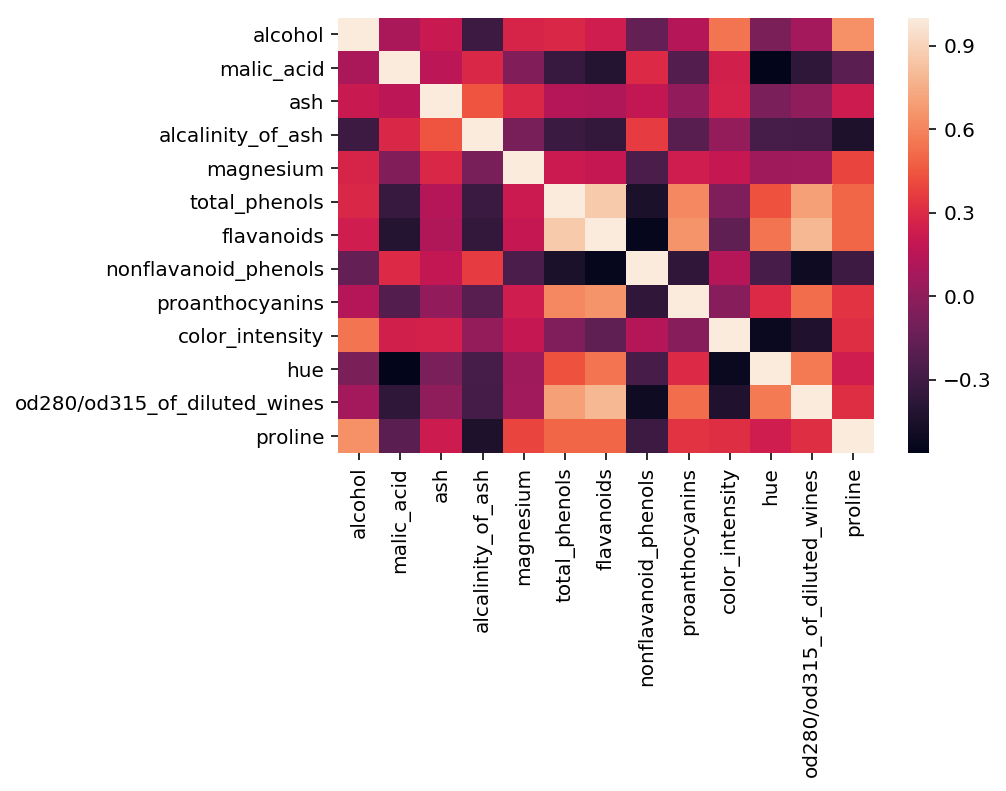

In [28]:
# A:

sns.heatmap(wine_df.corr())


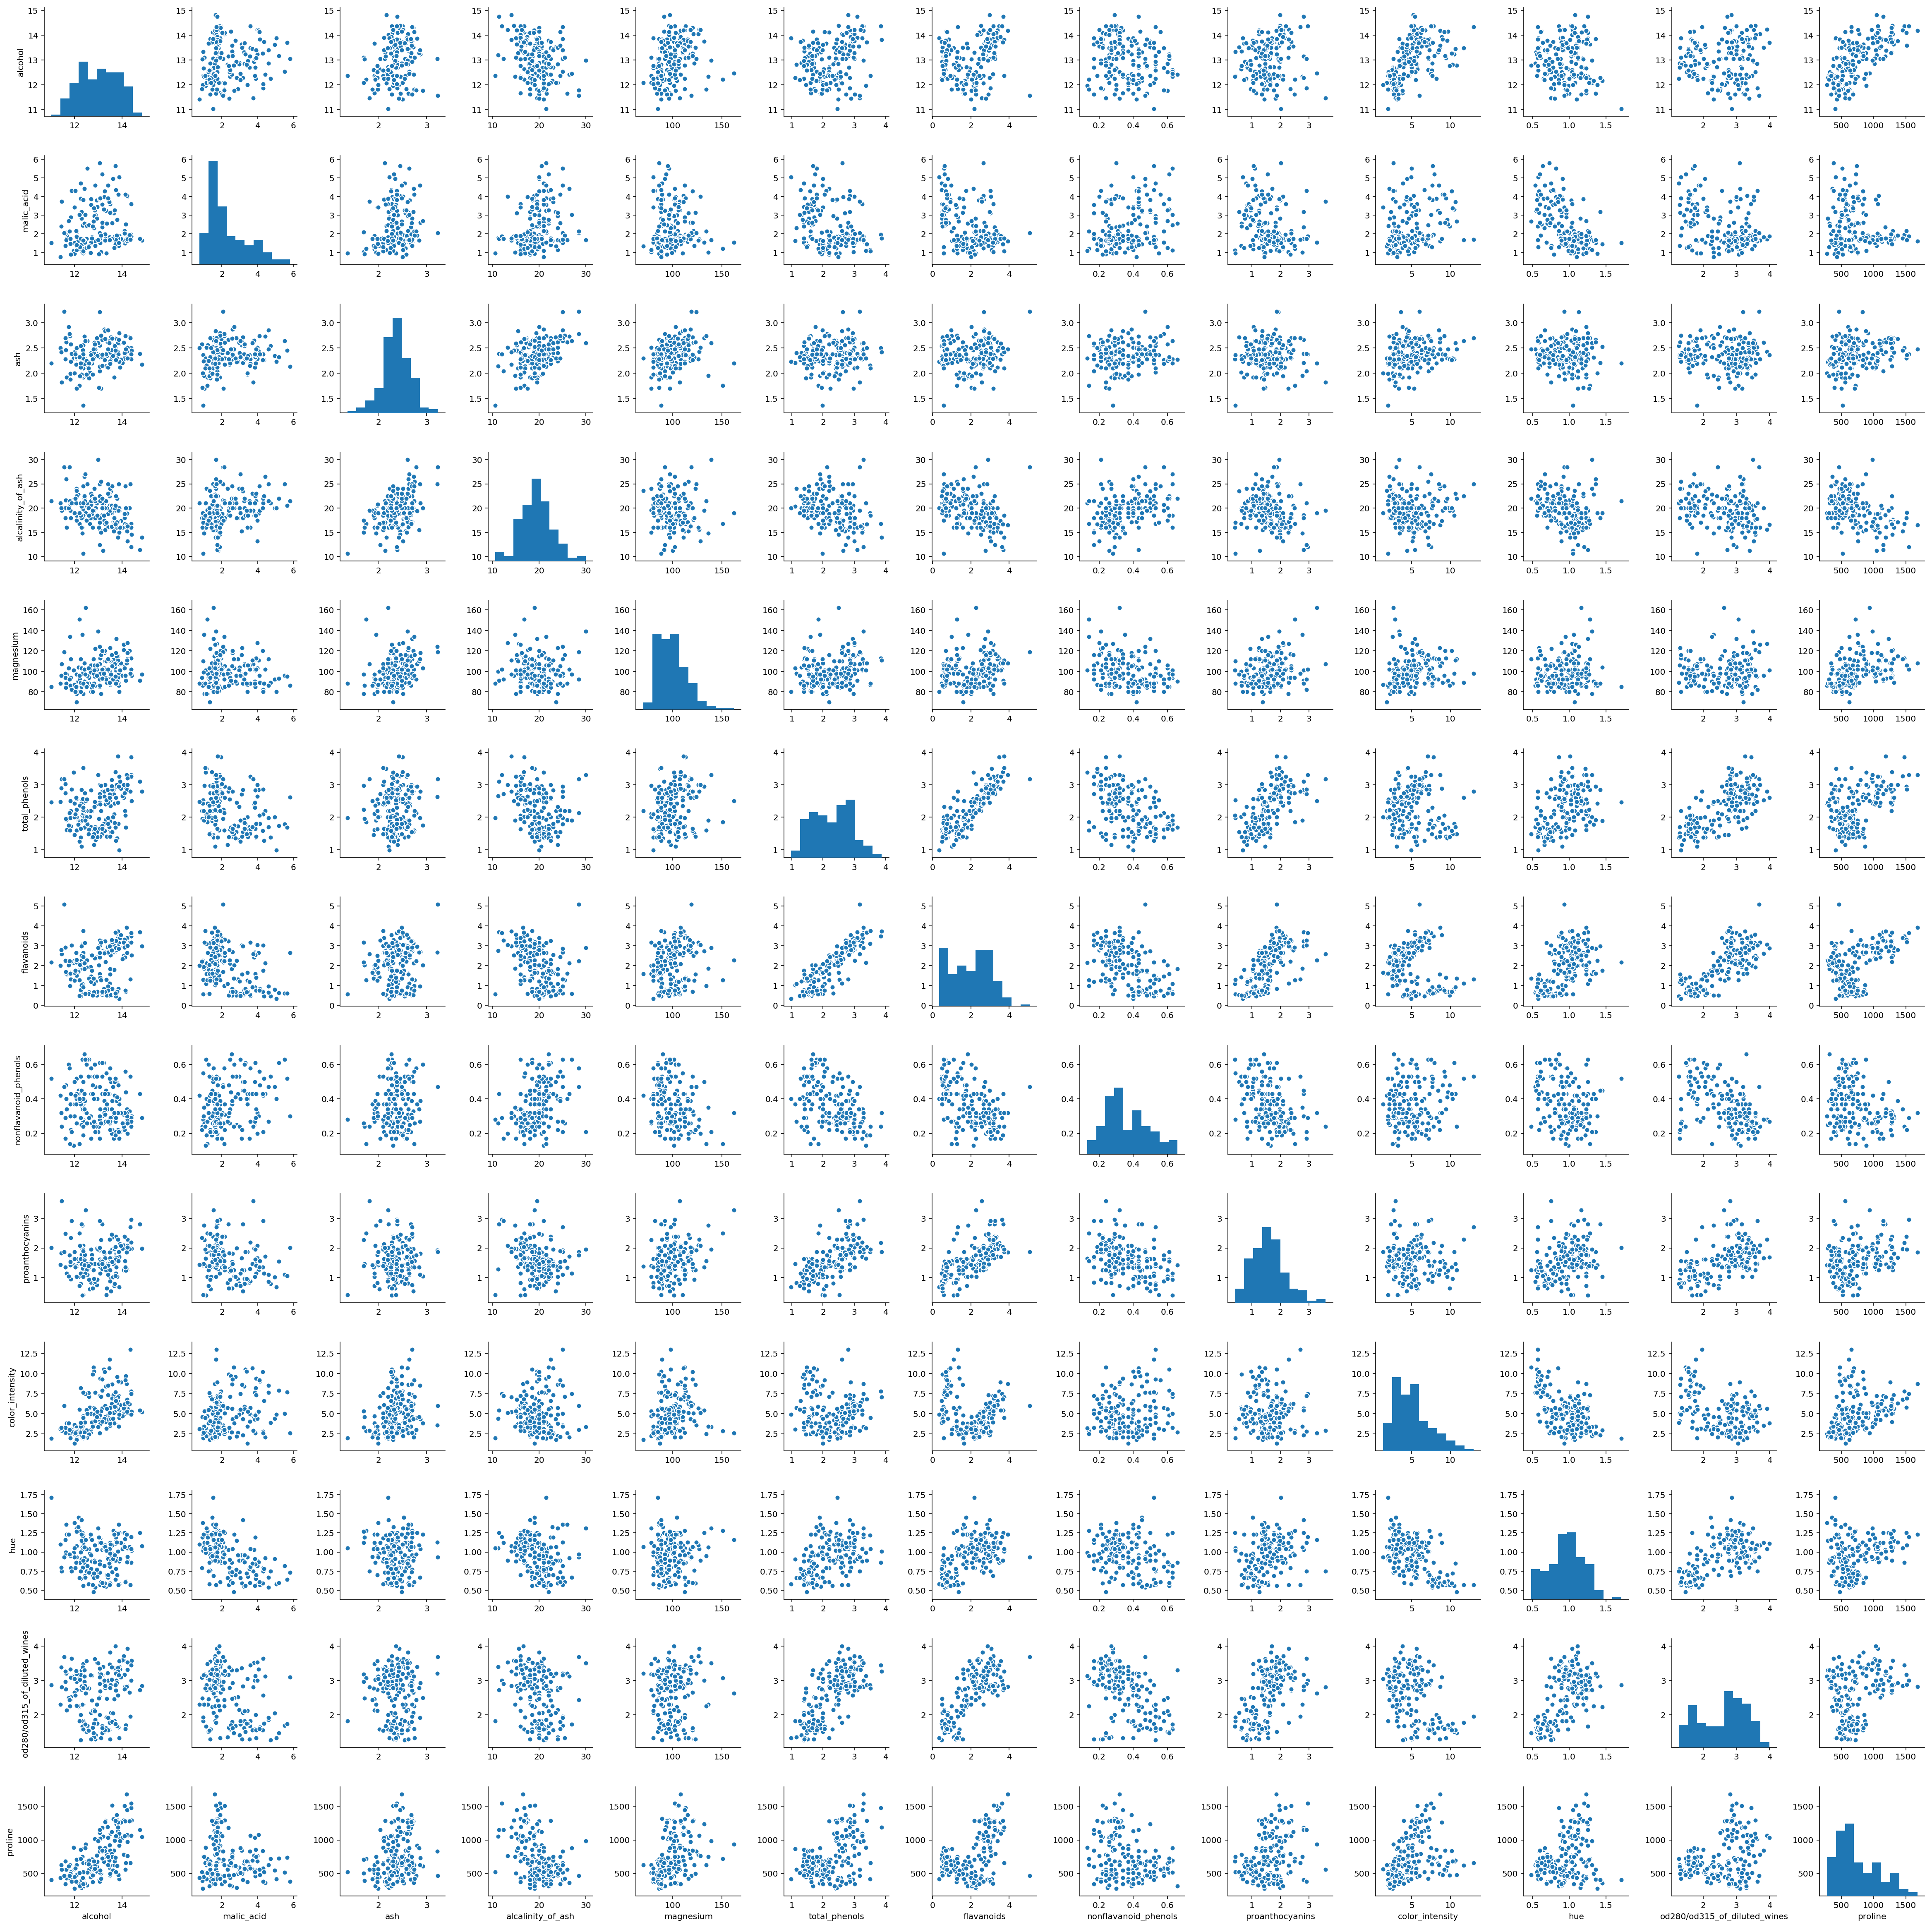

In [35]:
sns.pairplot(wine_df)

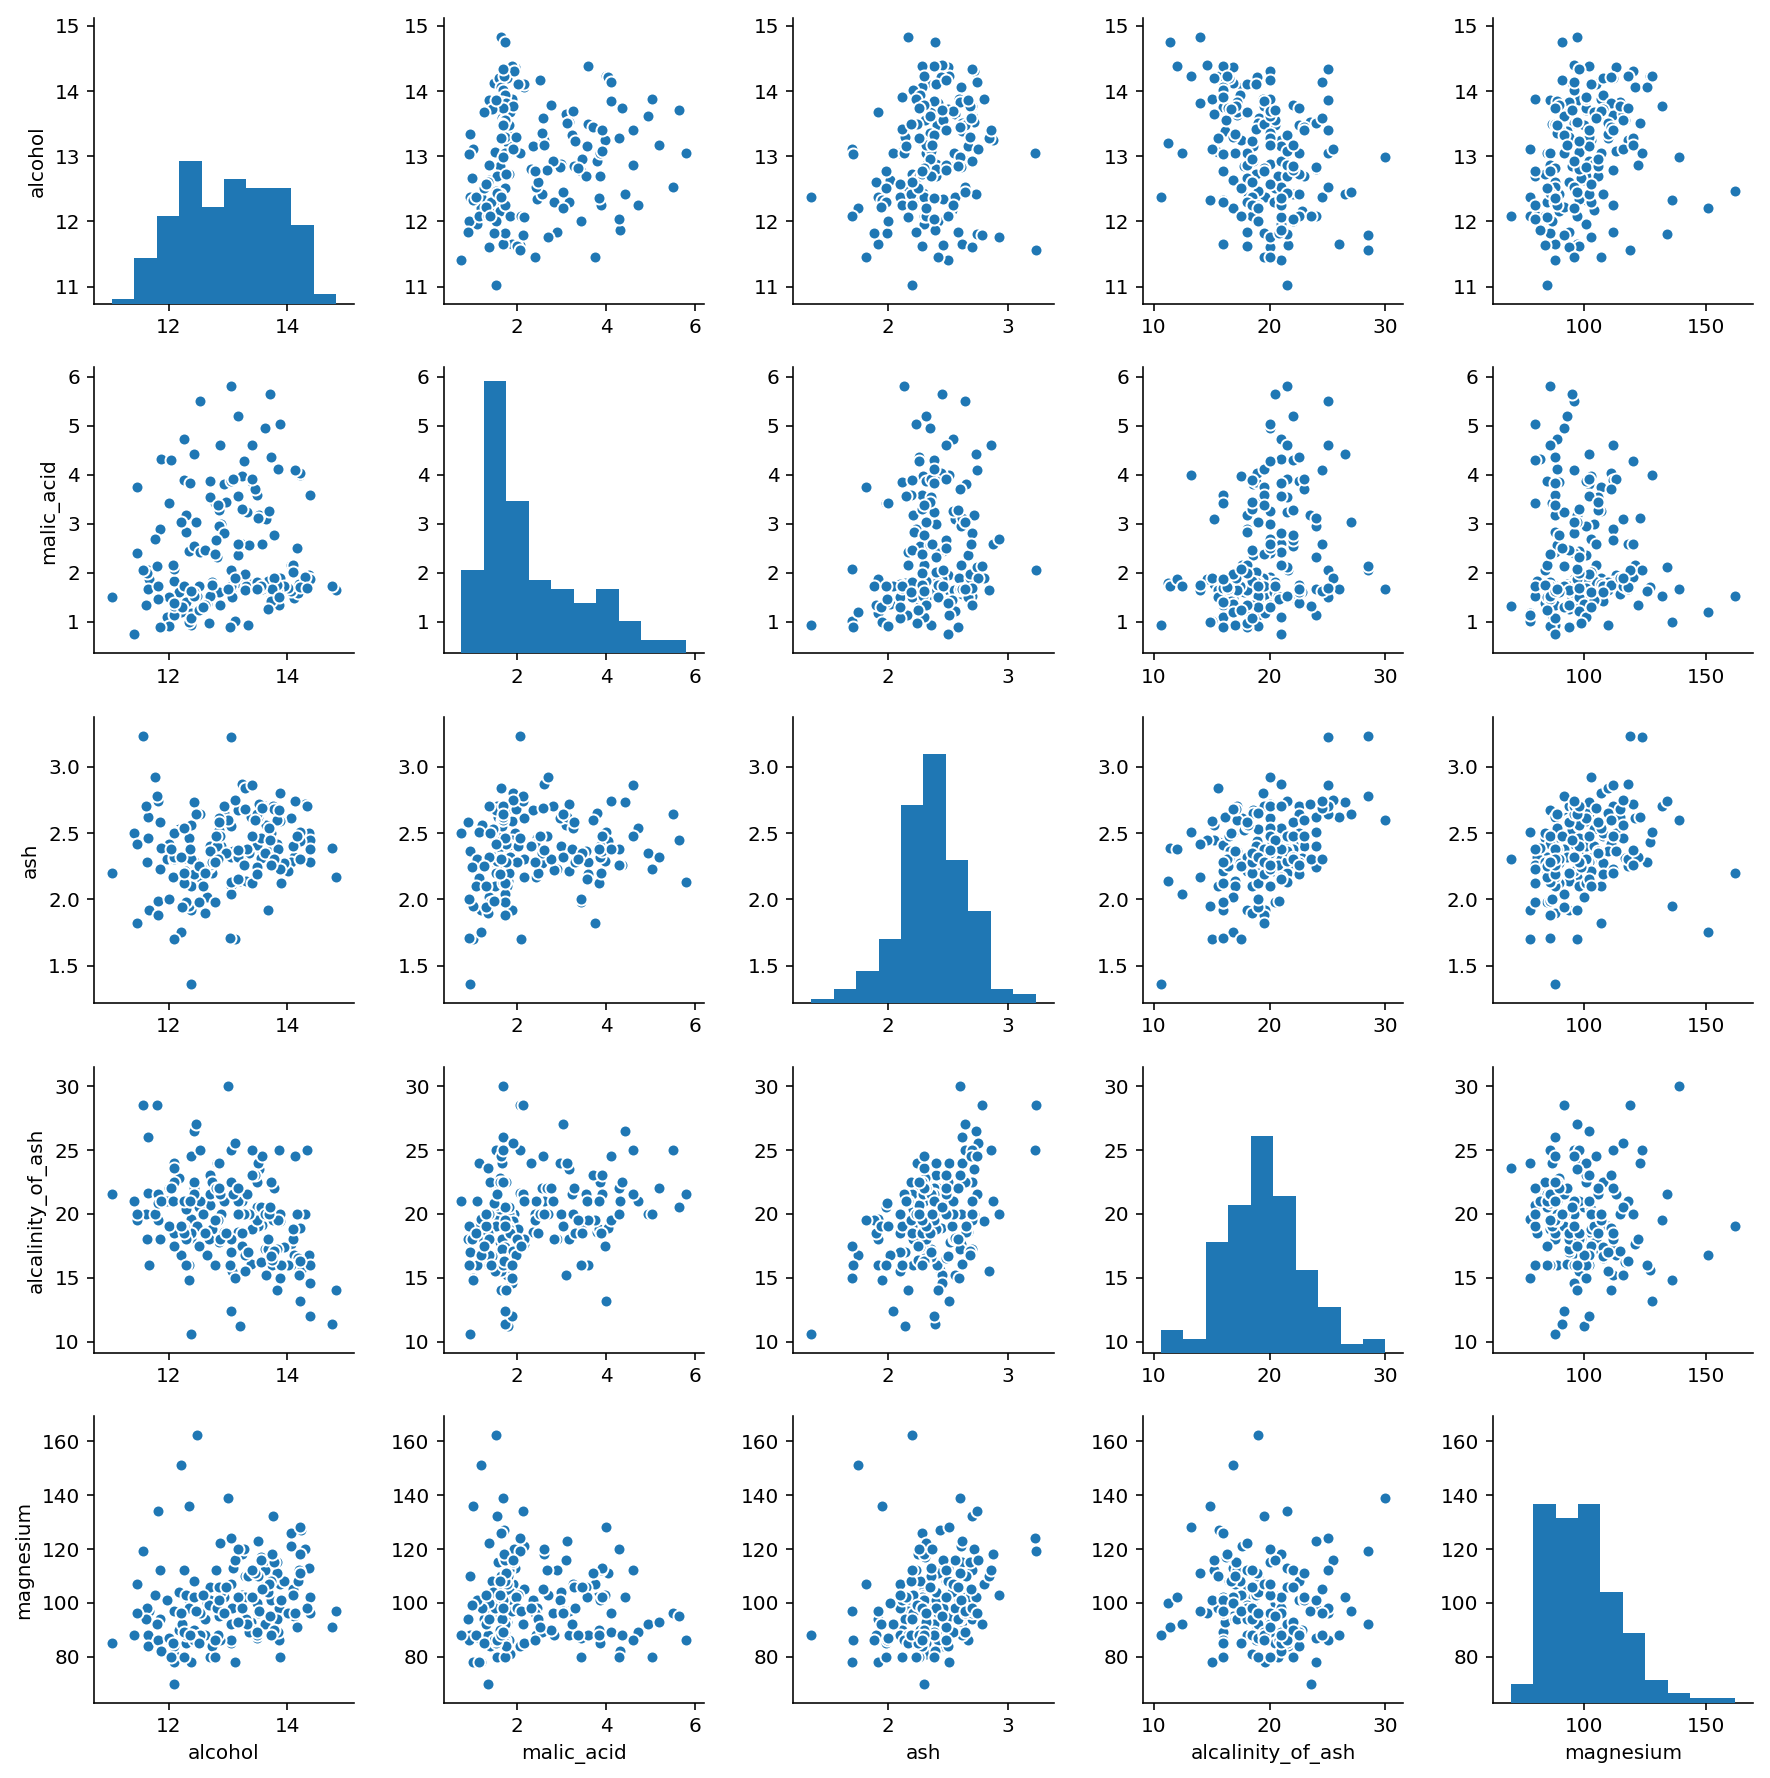

In [36]:
sns.pairplot(wine_df.iloc[:,:5])

In [41]:
sns.pairplot(wine_df.iloc[6:,:11]

SyntaxError: unexpected EOF while parsing (<ipython-input-41-8f272cc48b6a>, line 1)

<a id='kneighborsclassifier'></a>

## Using sklearn's `KNeighborsClassifier`

---

Let's see how the sklearn KNN classifier performs on our dataset predicting the malignant target class using cross-validation.

Load the KNN classifier like so:
```python
from sklearn.neighbors import KNeighborsClassifier
```

**We are going to set some arguments when instantiating the model:**
1. **n_neighbors** specifies how many neighbors will vote on the class
2. **weights** uniform weights indicate that all neighbors have the same weight
3. **metric** and **p**: when distance is minkowski (the default) and p == 2 (the default), _this is equivalent to the euclidean distance metric_


In [51]:
# A:

#1. Import
from sklearn.neighbors import KNeighborsClassifier

#2. Instantiate
knn = KNeighborsClassifier()
knn = KNeighborsClassifier(n_neighbors=5)

#3. Fir (aka 'train' your labelled data)
knn.fit(wine_df, y)

#4. Make new predictions or score
knn.predict(wine_df.sample(3))

array([0, 2, 1, 1, 1])

<a id='target-predictors'></a>
### Create your target vector and predictor matrix

The target should be the binary `malignant` column. The predictors are up to you.

In [53]:
# A:

wine_sample = wine_df.sample(5)

print "prediction:", knn.predict(wine_sample)
print "actual:    ", y[wine_sample.index]

prediction: [0 1 1 0 1]
actual:     [0 1 1 0 1]


### Fit our first K-nearest neighbors model to the wine data

The steps to using an sklearn model are:
1. Instantiated the model
2. Fit the instantiated model object to day (`X` and `y`)
3. Score or make predictions with your "trained model"

In [ ]:
#A:

see above

<a id='baseline'></a>
### Calculate the "baseline" accuracy

Before we can evaluate whether our classifier's accuracy is good or bad, we need to know the baseline accuracy.

**The baseline accuracy is the proportion of the majority class.**

For a binary classification, this means that the baseline accuracy is the percent of the dataset that is labeled malignant or benign, depending on whichever of malignant or benign is greater. This can be calculated:

```python
baseline = np.mean(y)  # if np.mean(y) is >= 0.5
baseline = 1. - np.mean(y) # if np.mean(y) is < 0.5
```

**It is critical that you know your baseline accuracy!**

If your dataset for example had 95 1's and 5 0's, and you got a 95% accuracy using KNN, if you had not looked at your baseline accuracy you may conclude that your classifier is doing great. In fact, it's doing no better than chance! The classifier could have guessed only 1's and gotten a 95% accuracy.

In [56]:
# A:

pd.Series(y).value_counts()

1    71
0    59
2    48
dtype: int64

<a id='cv-knn5'></a>
### What is the accuracy for a KNN model with 5 neighbors?

In [65]:

y_hat = knn.predict(wine_df)
y_hat == y

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False, False,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False, False,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [66]:
(y_hat == y).mean()

0.7865168539325843

In [57]:
# A:

knn.score(wine_df, y)

0.7865168539325843

<a id='cv-knn1'></a>
## Tuning your model for performance

As you can see the accuracy is already very high with 5 neighbors on the full dataset, but in industry, mere percentage point gains in performance could be a matter of millions of dollars. Let's see how well we can do!

Right now we have two main dials to turn:
    1. Feature selection ie which column or columns to include in the training set
    2. Choice of `n_neighbors` aka `k`

### <font color=blue>Partner Work (25 minutes)</font>   - Feature selection
We are going to start on feature selection. With your partner, start by exploring which columns will produce the best accuracy score using the default `n_neighbors=5`.

After our exploration, we will convene to share our findings as a class.

#### Teams

<img src=https://i.imgur.com/HFFCeUH.png width="30%" align=left>

### Feature selection strategies

- Segmenting based on different class labels
    - group bys
    - overlaid histograms
- trial and error - innefective brute force
- brute force

### <font color=blue>Partner Work (25 minutes)</font>   - Hyper-parameter tuning

Using the best features, explore what the best value of `k` is for this dataset. 

In [ ]:
# A: 

 ## Introduction to training and test sets
 
Our model has already seen and fit on the train data that we are using to produce an accuracy score.

![](https://cdn-images-1.medium.com/max/2000/1*-8_kogvwmL1H6ooN1A1tsQ.png)

Let's create a test that simulates fresh data that model might be predicting on when it is put into production.

In [63]:
# A:
from sklearn.model_selection import train_test_split



Are our choice of hyper-parameters and features the same as they were when we were validating based on a training set alone?

<a id='resources'></a>

## Additional resources

---


- Scott Foreman-Roe's [breakdown](http://scott.fortmann-roe.com/docs/BiasVariance.html) (required) of the bias-variance tradeoff featuring a discussion of KNN is an excellent read
- A [detailed discussion](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/) of KNN
- A long, applied example of KNN applied to [image classification](http://cs231n.github.io/classification/ )
- If academic breakdowns are your thing, be sure to visit [this](http://me.seekingqed.com/files/intro_KNN.pdf) resource
- Read the SKLearn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on implementing KNN
- Choosing the right [algorithm from SKLearn](http://scikit-learn.org/stable/tutorial/machine_learning_map/)
- A deeper dive into [Euclidian distance](http://www.econ.upf.edu/~michael/stanford/maeb4.pdf)
- Classifier comparsion from [SKLearn](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) (this is also in our [repository](https://github.com/ga-students/DSI-DC-2/blob/master/curriculum/Week-04/4.01%20Intro%20to%20Classification/classification-methods.py))